In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot(predictionFile:str, title1:str, title2:str):
    df = pd.read_csv(predictionFile)
    
    y_true = df["True_Label"].values
    y_pred = df["Predicted_Value"].values
    
    # Compute regression metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pearson_corr, _ = stats.pearsonr(y_true.flatten(), y_pred.flatten())  # Extract first value
    spearman_corr, _ = stats.spearmanr(y_true.flatten(), y_pred.flatten())  # Extract first value

    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R² Score: {r2:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    
    residuals = y_pred - y_true
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("True Affinity")
    plt.ylabel("Residual (Predicted - True)")
    plt.title(title2, fontsize = 10)
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle="--")  # Identity line
    plt.xlabel("True Affinity")
    plt.ylabel("Predicted Affinity")
    plt.title(title1, fontsize = 10)
    plt.show()

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_73977/2418045564.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["True_Label"], df["Predicted_Value"]], labels=["True", "Predicted"])


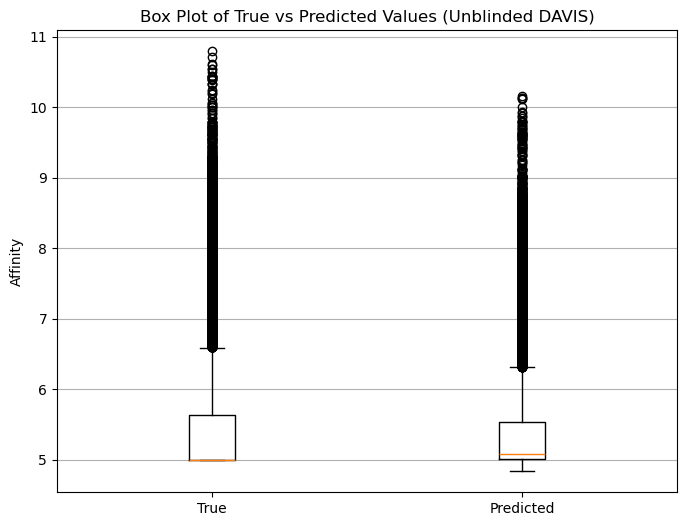

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "new/crossval_predictions_GINConvNet_davis_b3.csv"
df = pd.read_csv(file_path)

plt.figure(figsize=(8, 6))
plt.boxplot([df["True_Label"], df["Predicted_Value"]], labels=["True", "Predicted"])

plt.title("Box Plot of True vs Predicted Values (Unblinded DAVIS)")
plt.ylabel("Affinity")
plt.grid(axis='y')
plt.show()


Mean Squared Error (MSE): 0.221
Mean Absolute Error (MAE): 0.259
R² Score: 0.736
Spearman Correlation: 0.730
Pearson Correlation: 0.860


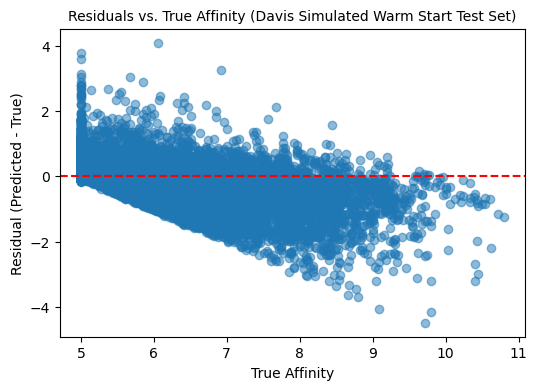

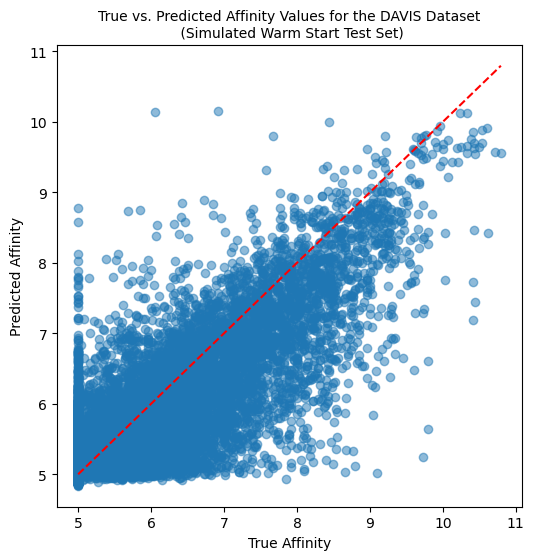

In [5]:
plot("new/crossval_predictions_GINConvNet_davis_b3.csv", "True vs. Predicted Affinity Values for the DAVIS Dataset\n (Simulated Warm Start Test Set)", "Residuals vs. True Affinity (Davis Simulated Warm Start Test Set)")

In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict

# List of file paths
file_paths = [f"new/final_test_predictions_GINConvNet_davis_b3_{i}.csv" for i in range(1, 6)]

# Store predictions per triplet
prediction_dict = defaultdict(list)

for i, path in enumerate(file_paths, start=1):
    df = pd.read_csv(path)
    df.drop(columns=["Fold"], errors="ignore", inplace=True)
    df["Fold"] = i 
    print(f"File {i}: {path} — {len(df)} rows")
    print(df.head(1))

    # Accumulate predictions for each triplet
    for _, row in df.iterrows():
        key = (row["Drug_ID"], row["Protein_ID"], row["True_Label"])
        prediction_dict[key].append((row["Predicted_Value"], i))

# Aggregate predictions
rows = []
for (d_id, p_id, true), values in prediction_dict.items():
    preds, folds = zip(*values)
    avg_pred = np.mean(preds)
    contributing_folds = ",".join(map(str, sorted(set(folds))))
    rows.append({
        "Drug_ID": d_id,
        "Protein_ID": p_id,
        "True_Label": true,
        "Predicted_Value": avg_pred,
        "Fold": contributing_folds 
    })

final_df = pd.DataFrame(rows)

output_path = "new/concatenated_final_test_predictions.csv"
final_df.to_csv(output_path, index=False)
concatenated_df = final_df
print(f"Saved aggregated predictions with Fold info to {output_path}")


File 1: new/final_test_predictions_GINConvNet_davis_b3_1.csv — 5712 rows
    Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0  10138260      SNARK     6.39794         5.411871     1
File 2: new/final_test_predictions_GINConvNet_davis_b3_2.csv — 5508 rows
    Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0  10427712        TXK         5.0         4.936027     2
File 3: new/final_test_predictions_GINConvNet_davis_b3_3.csv — 7072 rows
   Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0  6450551       GRK1         5.0         4.977173     3
File 4: new/final_test_predictions_GINConvNet_davis_b3_4.csv — 6256 rows
    Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0  11427553       ERK1         5.0         5.762062     4
File 5: new/final_test_predictions_GINConvNet_davis_b3_5.csv — 5508 rows
   Drug_ID Protein_ID  True_Label  Predicted_Value  Fold
0   208908      PRKCI         5.0         4.847114     5
Saved aggregated predictions with Fold info to new/concaten

In [7]:
import matplotlib.pyplot as plt

def plot_true_vs_predicted_by_fold(df, true_col="True_Label", pred_col="Predicted_Value", fold_col="Fold"):
    """
    Plots True vs Predicted values colored by fold.

    Parameters:
    - df: DataFrame containing the data
    - true_col: Column name for true labels
    - pred_col: Column name for predicted values
    - fold_col: Column name indicating the fold number
    """
    unique_folds = sorted(df[fold_col].unique())
    cmap = plt.get_cmap("tab10")

    plt.figure(figsize=(8, 6))
    
    for i, fold in enumerate(unique_folds):
        fold_data = df[df[fold_col] == fold]
        plt.scatter(fold_data[true_col], fold_data[pred_col],
                    label=f"Fold {fold}", color=cmap(i), alpha=0.6, edgecolors='k', linewidths=0.5)

    plt.plot([df[true_col].min(), df[true_col].max()],
             [df[true_col].min(), df[true_col].max()],
             color='gray', linestyle='--', linewidth=1.5, label="Ideal")

    plt.xlabel("True Label")
    plt.ylabel("Predicted Value")
    plt.title("True vs Predicted by Fold (BLINDED)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
import matplotlib.pyplot as plt
import math

def plot_true_vs_predicted_by_fold_grid(df, true_col="True_Label", pred_col="Predicted_Value", fold_col="Fold"):
    """
    Plots True vs Predicted values in separate subplots for each fold.

    Parameters:
    - df: DataFrame containing the data
    - true_col: Column name for true labels
    - pred_col: Column name for predicted values
    - fold_col: Column name indicating the fold number
    """
    unique_folds = sorted(df[fold_col].unique())
    n_folds = len(unique_folds)

    n_cols = math.ceil(math.sqrt(n_folds))
    n_rows = math.ceil(n_folds / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)

    vmin = df[true_col].min()-.5
    vmax = df[true_col].max()+.5

    for idx, fold in enumerate(unique_folds):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        fold_data = df[df[fold_col] == fold]
        ax.scatter(fold_data[true_col], fold_data[pred_col],
                   alpha=0.6, edgecolors='k', linewidths=0.5, color='tab:blue', label=f"Fold {fold}")
        
        ax.plot([vmin, vmax], [vmin, vmax], 'r--', linewidth=1.2, label="Ideal")
        ax.set_title(f"Fold {fold}")
        ax.set_xlabel("True Label")
        ax.set_ylabel("Predicted Value")
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)
        ax.grid(True)
        ax.legend()

    for idx in range(n_folds, n_rows * n_cols):
        row, col = divmod(idx, n_cols)
        axes[row][col].axis('off')

    fig.suptitle("True vs Predicted per Fold (BLINDED)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def boxplot_true_vs_pred_by_fold(df, true_col="True_Label", pred_col="Predicted_Value", fold_col="Fold"):
    """
    Creates side-by-side box plots of true and predicted values per fold.
    
    Parameters:
    - df: DataFrame containing true labels, predicted values, and fold information
    - true_col: Name of the column with true labels
    - pred_col: Name of the column with predicted values
    - fold_col: Name of the column with fold identifiers
    """
    melted = pd.melt(
        df,
        id_vars=[fold_col],
        value_vars=[true_col, pred_col],
        var_name="Type",
        value_name="Value"
    )
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted, x=fold_col, y="Value", hue="Type", palette="Set1", showfliers=True)

    plt.title("True vs Predicted Value Distributions per Fold (BLINDED)", fontsize=14)
    plt.xlabel("Fold")
    plt.ylabel("Value")
    plt.legend(title="Value Type")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()




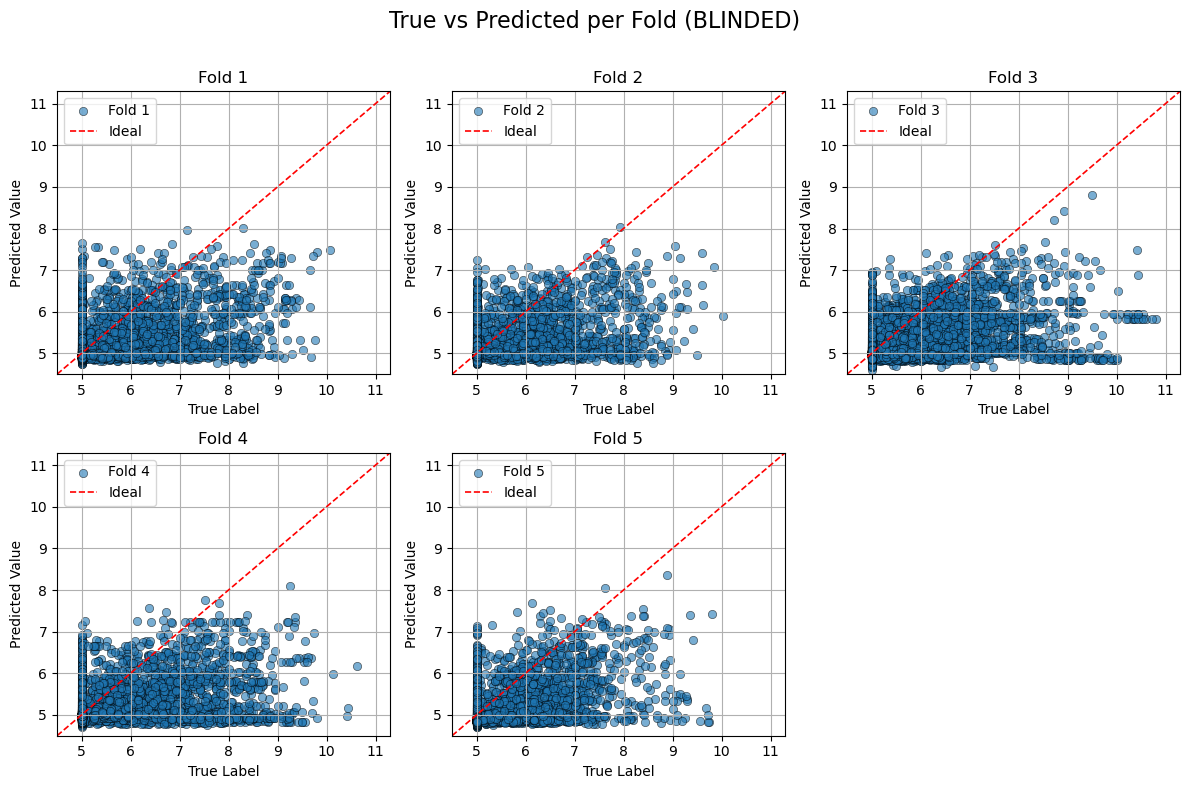

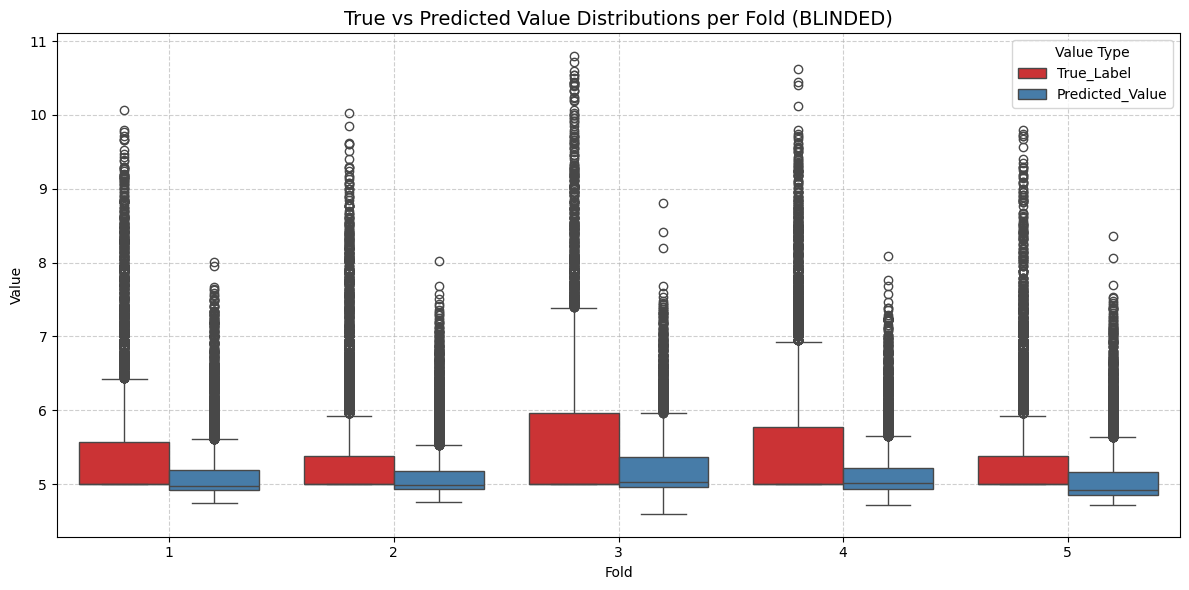

In [8]:
plot_true_vs_predicted_by_fold_grid(concatenated_df)
boxplot_true_vs_pred_by_fold(concatenated_df)

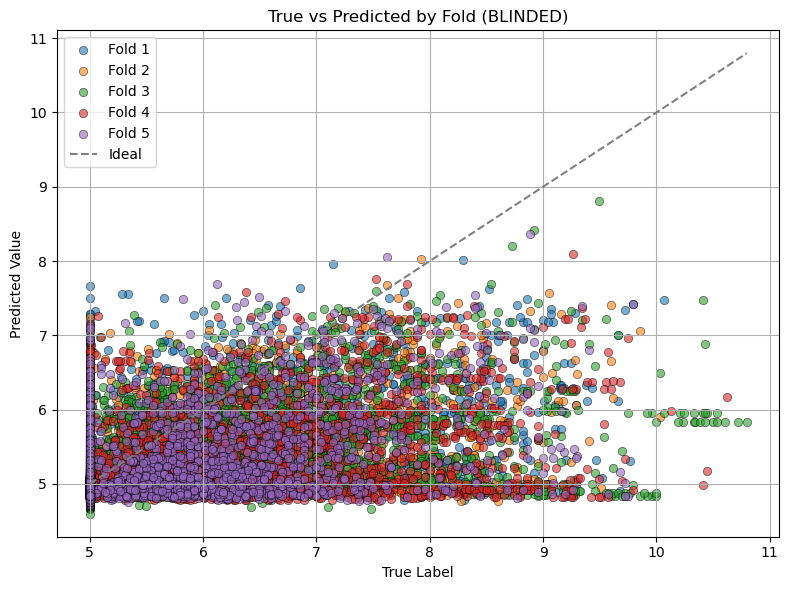

In [9]:
plot_true_vs_predicted_by_fold(concatenated_df)

Mean Squared Error (MSE): 0.734
Mean Absolute Error (MAE): 0.462
R² Score: 0.123
Spearman Correlation: 0.416
Pearson Correlation: 0.486


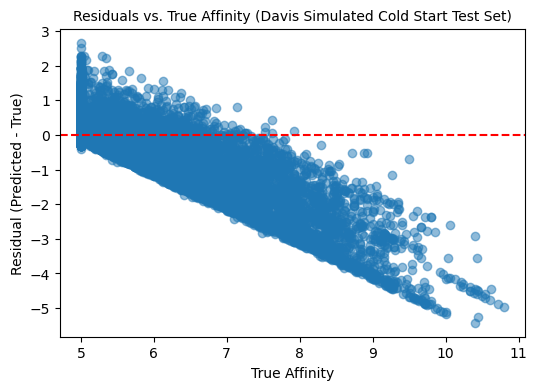

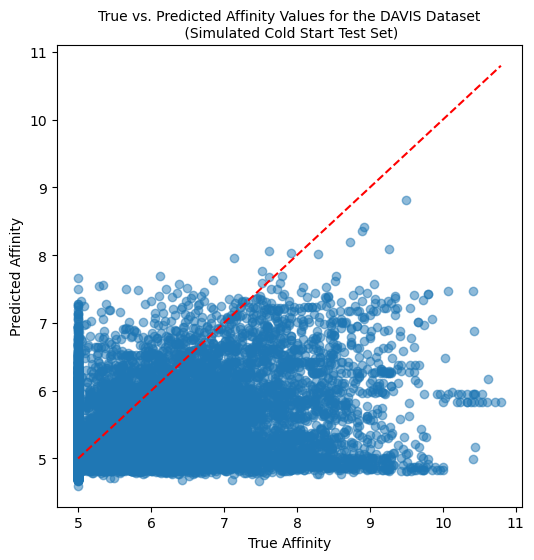

In [10]:
plot("new/concatenated_final_test_predictions.csv", "True vs. Predicted Affinity Values for the DAVIS Dataset\n (Simulated Cold Start Test Set)", "Residuals vs. True Affinity (Davis Simulated Cold Start Test Set)")

Mean Squared Error (MSE): 5.346
Mean Absolute Error (MAE): 2.193
R² Score: -10.378
Spearman Correlation: 0.180
Pearson Correlation: 0.118


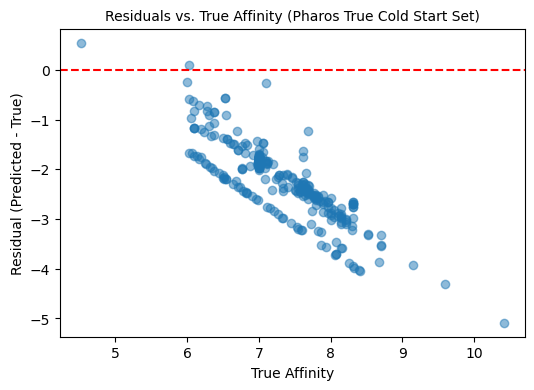

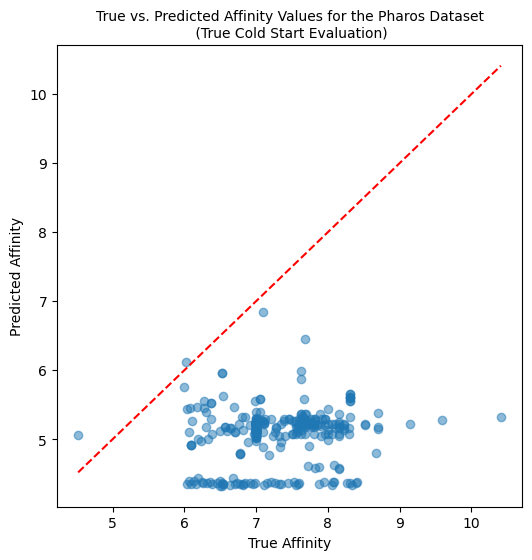

In [11]:
plot(
    "new/pharos_test_predictions_GINConvNet.csv",
    "True vs. Predicted Affinity Values for the Pharos Dataset\n (True Cold Start Evaluation)",
    "Residuals vs. True Affinity (Pharos True Cold Start Set)"
)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_blinded_vs_unblinded(unblinded_file: str, blinded_file: str, save_path_prefix: str = None):
    unblinded_df = pd.read_csv(unblinded_file)
    blinded_df = pd.read_csv(blinded_file)

    print("Un:", len(unblinded_df))
    print(len(blinded_df))

    merged_df = pd.merge(
        unblinded_df,
        blinded_df,
        on=["Drug_ID", "Protein_ID", "True_Label"],
        suffixes=("_unblinded", "_blinded")
    )
    print("Merged:", len(merged_df))

    # Residuals
    merged_df["Residual"] = merged_df["Predicted_Value_blinded"] - merged_df["Predicted_Value_unblinded"]

    overall_stats = {
        "Mean_Difference": merged_df["Residual"].mean(),
        "Max_Difference": merged_df["Residual"].max(),
        "Min_Difference": merged_df["Residual"].min(),
        "Average_Positive_Difference": merged_df[merged_df["Residual"] > 0]["Residual"].mean(),
        "Average_Negative_Difference": merged_df[merged_df["Residual"] < 0]["Residual"].mean(),
        "Count_Positive_Differences": (merged_df["Residual"] > 0).sum(),
        "Count_Negative_Differences": (merged_df["Residual"] < 0).sum(),
    }

    print("Overall Statistics for Residuals (Blinded - Unblinded):")
    for stat, value in overall_stats.items():
        print(f"{stat}: {value:.4f}")

    plt.figure(figsize=(7, 6))
    plt.scatter(
        merged_df["Predicted_Value_unblinded"],
        merged_df["Predicted_Value_blinded"],
        alpha=0.6,
        linewidths=0.5
    )
    plt.plot(
        [merged_df["Predicted_Value_unblinded"].min(), merged_df["Predicted_Value_unblinded"].max()],
        [merged_df["Predicted_Value_unblinded"].min(), merged_df["Predicted_Value_unblinded"].max()],
        'r--', label='y = x'
    )
    plt.xlabel("Simulated Warm Start Predicted Value")
    plt.ylabel("Simulated Cold Start Predicted Value")
    plt.title("Simulated Cold vs. Warm Start Predictions")
    plt.legend()
    plt.grid(True)
    if save_path_prefix:
        plt.savefig(f"{save_path_prefix}_scatter.png", bbox_inches='tight')
        print(f"Scatter plot saved to {save_path_prefix}_scatter.png")
    else:
        plt.show()

    plt.figure(figsize=(7, 5))
    plt.scatter(
        merged_df["Predicted_Value_unblinded"],
        merged_df["Residual"],
        alpha=0.6,
        linewidths=0.5
    )
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel("Unblinded Predicted Value")
    plt.ylabel("Residual (Blinded - Unblinded)")
    plt.title("Residual (Blinded - Unblinded) Plot")
    plt.grid(True)
    if save_path_prefix:
        plt.savefig(f"{save_path_prefix}_residual.png", bbox_inches='tight')
        print(f"Residual plot saved to {save_path_prefix}_residual.png")
    else:
        plt.show()


Un: 27621
27621
Merged: 27621
Overall Statistics for Residuals (Blinded - Unblinded):
Mean_Difference: -0.2608
Max_Difference: 2.3357
Min_Difference: -4.9491
Average_Positive_Difference: 0.2336
Average_Negative_Difference: -0.4307
Count_Positive_Differences: 7065.0000
Count_Negative_Differences: 20556.0000


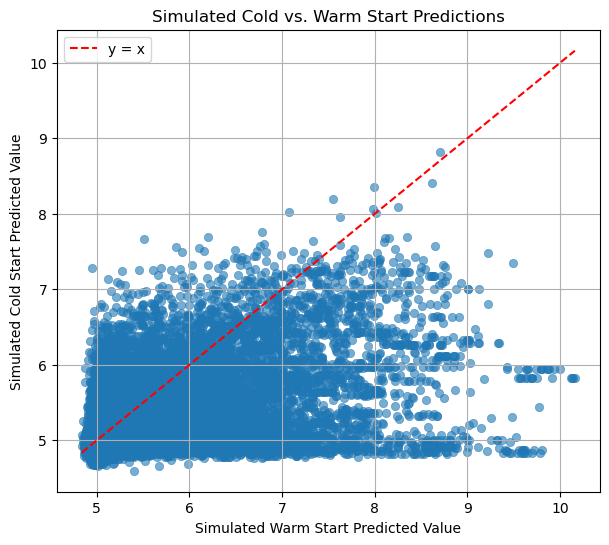

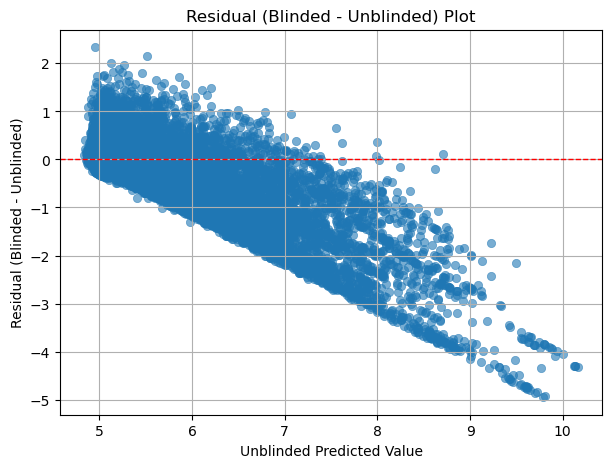

In [13]:
plot_blinded_vs_unblinded("new/crossval_predictions_GINConvNet_davis_b3.csv", "new/concatenated_final_test_predictions.csv")

In [14]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_multiple_predictions(prediction_dict: dict):
    plt.figure(figsize=(6, 6))
    for label, file_path in prediction_dict.items():
        df = pd.read_csv(file_path)
        y_true = df["True_Label"].values
        y_pred = df["Predicted_Value"].values

        # Regression metrics
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        pearson_corr, _ = stats.pearsonr(y_true.flatten(), y_pred.flatten())
        spearman_corr, _ = stats.spearmanr(y_true.flatten(), y_pred.flatten())

        print(f"=== {label} ===")
        print(f"Mean Squared Error (MSE): {mse:.3f}")
        print(f"Mean Absolute Error (MAE): {mae:.3f}")
        print(f"R² Score: {r2:.3f}")
        print(f"Spearman Correlation: {spearman_corr:.3f}")
        print(f"Pearson Correlation: {pearson_corr:.3f}")
        print()

        plt.scatter(y_true, y_pred, alpha=0.3, s=10, edgecolors='k', linewidths=0.2, label=label)

    # Identity line
    min_val, max_val = plt.xlim()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel("True Affinity")
    plt.ylabel("Predicted Affinity")
    plt.title("True vs Predicted Affinities")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    for label, file_path in prediction_dict.items():
        df = pd.read_csv(file_path)
        y_true = df["True_Label"].values
        y_pred = df["Predicted_Value"].values
        residuals = y_pred - y_true

        plt.scatter(y_true, residuals, alpha=0.3, s=10, edgecolors='k', linewidths=0.2, label=label)

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("True Affinity")
    plt.ylabel("Residual (Predicted - True)")
    plt.title("Residuals of Predictions")
    plt.legend()
    plt.grid(True)
    plt.show()


=== Unblinded ===
Mean Squared Error (MSE): 0.221
Mean Absolute Error (MAE): 0.259
R² Score: 0.736
Spearman Correlation: 0.730
Pearson Correlation: 0.860

=== Blinded ===
Mean Squared Error (MSE): 0.734
Mean Absolute Error (MAE): 0.462
R² Score: 0.123
Spearman Correlation: 0.416
Pearson Correlation: 0.486

=== Pharos ===
Mean Squared Error (MSE): 5.346
Mean Absolute Error (MAE): 2.193
R² Score: -10.378
Spearman Correlation: 0.180
Pearson Correlation: 0.118



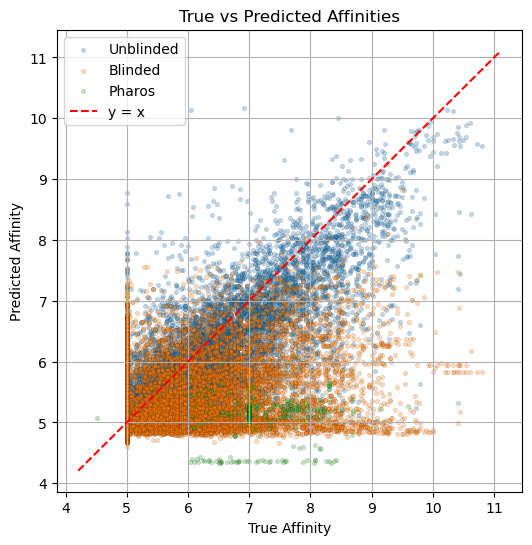

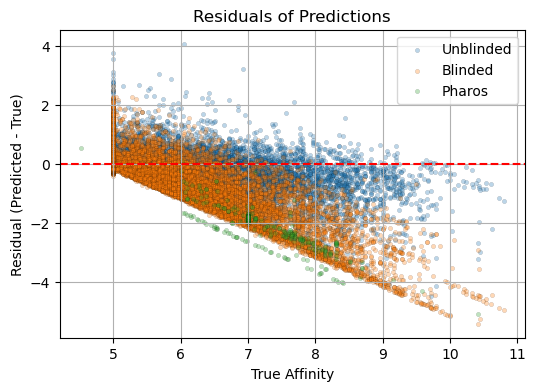

In [15]:
files = [
    "new/crossval_predictions_GINConvNet_davis_b3.csv",
    "new/concatenated_final_test_predictions.csv",
    "new/pharos_test_predictions_GINConvNet.csv"
]
labels = ["Unblinded", "Blinded", "Pharos"]

# dictionary of labels to file paths
prediction_dict = dict(zip(labels, files))

plot_multiple_predictions(prediction_dict)

27621


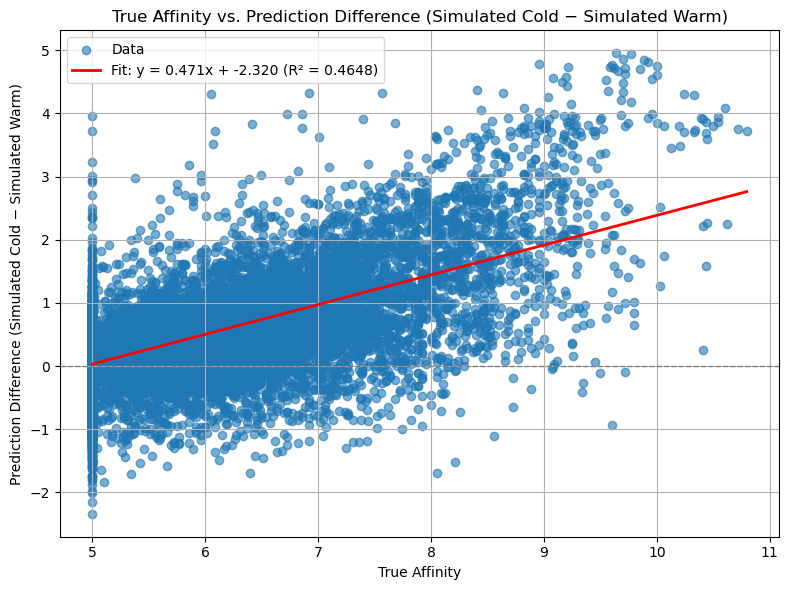

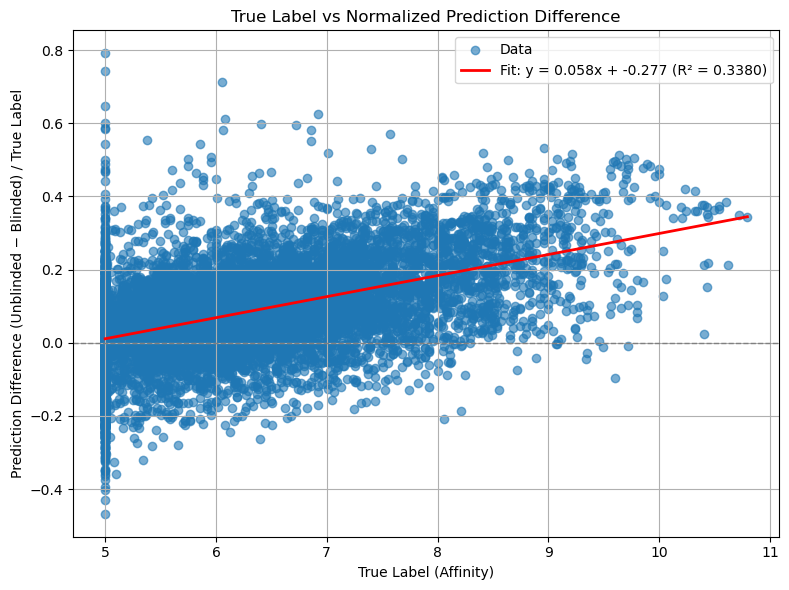

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# File paths
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"

# Load both files
df_unblinded = pd.read_csv(unblinded_file)
df_blinded = pd.read_csv(blinded_file)

# Rename prediction columns to distinguish
df_unblinded = df_unblinded.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
df_blinded = df_blinded.rename(columns={"Predicted_Value": "Blinded_Prediction"})

# Merge on Drug_ID and Protein_ID
merged_df = pd.merge(
    df_unblinded[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    df_blinded[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)
print(len(merged_df))

# --- Plot 1: Raw Difference ---
merged_df["Prediction_Diff"] = merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]

x = merged_df["True_Label"]
y = merged_df["Prediction_Diff"]
coeffs = np.polyfit(x, y, deg=1)
poly_eq = np.poly1d(coeffs)
y_pred = poly_eq(x)
r_squared = r2_score(y, y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, label="Data")
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = poly_eq(x_fit)
plt.plot(x_fit, y_fit, color='red', linewidth=2,
         label=f"Fit: y = {coeffs[0]:.3f}x + {coeffs[1]:.3f} (R² = {r_squared:.4f})")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("True Affinity")
plt.ylabel("Prediction Difference (Simulated Cold − Simulated Warm)")
plt.title("True Affinity vs. Prediction Difference (Simulated Cold − Simulated Warm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Normalized Difference ---
merged_df["Prediction_Diff"] = (
    merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]
) / merged_df["True_Label"]

x = merged_df["True_Label"]
y = merged_df["Prediction_Diff"]
coeffs_norm = np.polyfit(x, y, deg=1)
poly_eq_norm = np.poly1d(coeffs_norm)
y_pred_norm = poly_eq_norm(x)
r_squared_norm = r2_score(y, y_pred_norm)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, label="Data")
y_fit_norm = poly_eq_norm(x_fit)
plt.plot(x_fit, y_fit_norm, color='red', linewidth=2,
         label=f"Fit: y = {coeffs_norm[0]:.3f}x + {coeffs_norm[1]:.3f} (R² = {r_squared_norm:.4f})")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("True Label (Affinity)")
plt.ylabel("Prediction Difference (Unblinded − Blinded) / True Label")
plt.title("True Label vs Normalized Prediction Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As the true affinity increases, the relative difference between unblinded and blinded predictions also increases. The bias introduced by blinding is not uniform across the affinity spectrum—it’s worse for high-affinity targets.

In [17]:
unblinded_file = "new/crossval_predictions_GINConvNet_davis_b3.csv"
blinded_file = "new/concatenated_final_test_predictions.csv"
pharos_file = "new/pharos_test_predictions_GINConvNet.csv"

def load_xy(file):
    df = pd.read_csv(file)
    x = df["True_Label"].values
    y = df["Predicted_Value"].values
    return np.column_stack((x, y))

unblinded = load_xy(unblinded_file)
blinded = load_xy(blinded_file)
pharos = load_xy(pharos_file)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from scipy.spatial import ConvexHull, Delaunay

def compute_directional_CHR_from_arrays(unblinded, blinded, min_points=3):
    """
    Computes directional CHR using raw NumPy arrays of unblinded and blinded points.
    Format: each array is shape (N, 2) with [True_Label, Prediction].

    Returns:
    - chr_value: scalar CHR (fraction of points outside)
    - directions: list of unit direction vectors from hull boundary to outside points
    - magnitudes: list of distances from each outside point to the convex hull
    - inside_mask: boolean array indicating which blinded points are inside
    """
    if len(unblinded) < min_points:
        raise ValueError("Not enough unblinded points to construct convex hull.")

    try:
        hull = ConvexHull(unblinded)
        hull_points = unblinded[hull.vertices]
        boundary = LineString(hull_points.tolist() + [hull_points[0].tolist()])  # close the loop

        delaunay = Delaunay(hull_points)
        inside_mask = delaunay.find_simplex(blinded) >= 0
        outside_points = blinded[~inside_mask]

        directions = []
        magnitudes = []

        for p in outside_points:
            point = Point(p)
            nearest = boundary.interpolate(boundary.project(point))
            vec = np.array(p) - np.array([nearest.x, nearest.y])
            mag = np.linalg.norm(vec)
            if mag > 1e-8:
                directions.append(vec / mag)
                magnitudes.append(mag)
            else:
                directions.append(np.array([0.0, 0.0]))
                magnitudes.append(0.0)

        chr_value = len(outside_points) / len(blinded)
        return chr_value, directions, magnitudes, inside_mask

    except Exception as e:
        print(f"Convex hull computation failed: {e}")
        return np.nan, [], [], np.array([False] * len(blinded))


import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import matplotlib.patches as mpatches

def plot_directional_CHR_from_arrays(unblinded, blinded, directions, magnitudes, inside_mask,
                                     chr_value, scale=0.2, title="Directional CHR Plot"):
    """
    Plots convex hull, unblinded and blinded points, and arrows from outside points toward the hull.

    Parameters:
    - unblinded: Nx2 array of [True_Label, Prediction]
    - blinded: Mx2 array of [True_Label, Prediction]
    - directions: unit vectors from outside points (same length as magnitudes)
    - magnitudes: distances from outside points to the convex hull
    - inside_mask: boolean mask (True for inside, False for outside)
    - chr_value: scalar CHR
    - scale: arrow length scaling
    - title: plot title
    """
    outside_points = blinded[~inside_mask]

    hull = ConvexHull(unblinded)
    plt.figure(figsize=(8, 6))

    # Plot points
    plt.scatter(unblinded[:, 0], unblinded[:, 1], c='blue', alpha=0.5, label="Unblinded")
    plt.scatter(blinded[:, 0], blinded[:, 1], c='green', alpha=0.5, label="Blinded")
    plt.scatter(outside_points[:, 0], outside_points[:, 1], c='red', marker='x', label="Outside Points")

    # Plot convex hull
    for simplex in hull.simplices:
        plt.plot(unblinded[simplex, 0], unblinded[simplex, 1], 'k--')

    # Plot directional deviation arrows
    for p, d, m in zip(outside_points, directions, magnitudes):
        end = p + d * (scale * m)
        plt.arrow(p[0], p[1], end[0] - p[0], end[1] - p[1],
                  head_width=0.05, head_length=0.1, fc='yellow', ec='yellow', alpha=0.7)

    # Custom legend entry for direction arrows
    yellow_patch = mpatches.Patch(color='yellow', label='Direction of Deviation')

    plt.legend(handles=[
        plt.Line2D([], [], marker='o', color='w', label='Simulated Warm Start', markerfacecolor='blue', alpha=0.5),
        plt.Line2D([], [], marker='o', color='w', label='True Cold Start (Pharos)', markerfacecolor='green', alpha=0.5),
        plt.Line2D([], [], marker='x', color='red', linestyle='None', label='Outside Convex Hull'),
        yellow_patch
    ])


    plt.title(f"{title} (CHR = {chr_value:.4f})")
    plt.xlabel("True Affinity")
    plt.ylabel("Predicted Affinity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




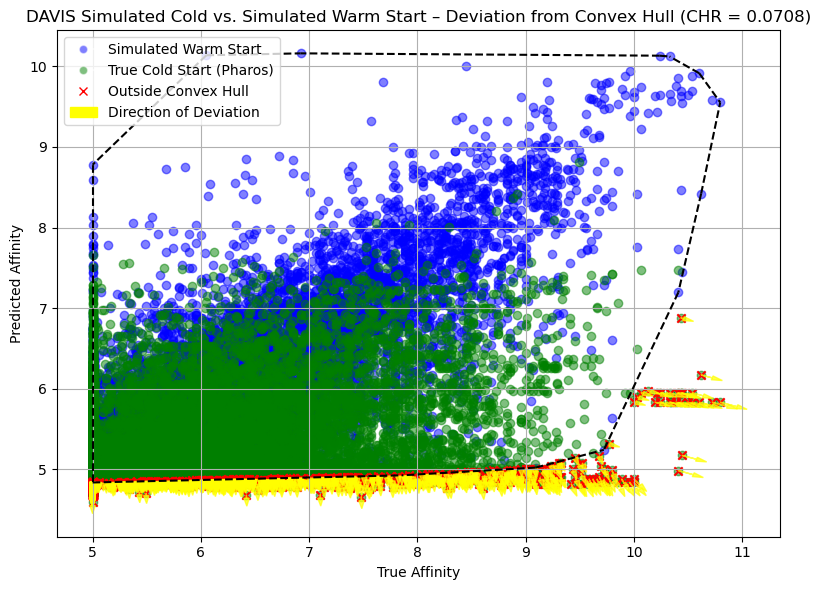

27621
27621
CHR: 0.0708
Number of outliers: 1956
Average deviation distance: 0.0469
Average direction vector: [ 0.03875438 -0.988342  ]
Unit direction: [ 0.03918139 -0.99923211]
Magnitude of average direction (coherence): 0.9891015150002865


In [19]:
# Compute and plot CHR for DAVIS blinded
chr_blinded, directions_b, magnitudes_b, mask_b = compute_directional_CHR_from_arrays(unblinded, blinded)
plot_directional_CHR_from_arrays(unblinded, blinded, directions_b, magnitudes_b, mask_b, chr_blinded,
                                 title="DAVIS Simulated Cold vs. Simulated Warm Start – Deviation from Convex Hull")

print(len(unblinded))
print(len(blinded))
print(f"CHR: {chr_blinded:.4f}")
print(f"Number of outliers: {len(magnitudes_b)}")
print(f"Average deviation distance: {np.mean(magnitudes_b):.4f}")
# Stack directions into a 2D array
direction_array = np.vstack(directions_b)  # shape (N, 2)

# Vector sum and mean direction
mean_vector = direction_array.mean(axis=0)
mean_magnitude = np.linalg.norm(mean_vector)

# Unit vector of average direction
mean_unit_direction = mean_vector / mean_magnitude if mean_magnitude != 0 else np.array([0.0, 0.0])

print("Average direction vector:", mean_vector)
print("Unit direction:", mean_unit_direction)
print("Magnitude of average direction (coherence):", mean_magnitude)

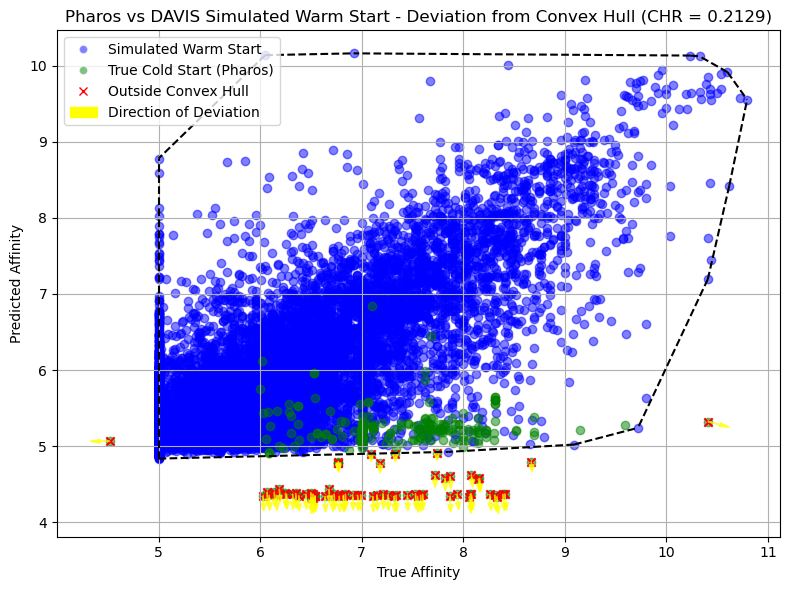

CHR: 0.2129
Number of outliers: 66
Average deviation distance: 0.4653
Average direction vector: [ 0.03860013 -0.97375568]
Unit direction: [ 0.03960936 -0.99921524]
Magnitude of average direction (coherence): 0.9745204396648737


In [20]:
chr_val_p, directions_p, magnitudes_p, mask_p = compute_directional_CHR_from_arrays(unblinded, pharos)
plot_directional_CHR_from_arrays(unblinded, pharos, directions_p, magnitudes_p, mask_p, chr_val_p, title="Pharos vs DAVIS Simulated Warm Start - Deviation from Convex Hull")

print(f"CHR: {chr_val_p:.4f}")
print(f"Number of outliers: {len(magnitudes_p)}")
print(f"Average deviation distance: {np.mean(magnitudes_p):.4f}")
# Stack directions into a 2D array
direction_array = np.vstack(directions_p)  # shape (N, 2)

# Vector sum and mean direction
mean_vector = direction_array.mean(axis=0)
mean_magnitude = np.linalg.norm(mean_vector)
#Add math definition

# Unit vector of average direction
mean_unit_direction = mean_vector / mean_magnitude if mean_magnitude != 0 else np.array([0.0, 0.0])

print("Average direction vector:", mean_vector)
print("Unit direction:", mean_unit_direction)
print("Magnitude of average direction (coherence):", mean_magnitude)
